In [4]:
import os
import numpy as np
import matplotlib
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.manifold import TSNE
import phate
import hdbscan
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score


In [2]:
os.chdir('..')
import data_loader

In [3]:
PROJECT_PATH = '/home/mila/s/shuang.ni/phate_genetics/shuang/'
SCRATCH_PATH = '/home/mila/s/shuang.ni/scratch/phate_genetics/'
DATA_PATH = SCRATCH_PATH + '1KGP/'
SAVE_PATH = SCRATCH_PATH + 'results/'
Figure_PATH = PROJECT_PATH + 'figures/'

In [5]:
fname = '1000G.2504_WGS30x.GSA17k_MHI.intersectGSA.miss10perc.maf0.05.pruned.autosomes.noHLA.phased_imputed_V1.hdf5'

In [6]:
inputs, class_labels, samples, snp_names, class_label_names = data_loader.load_data_1000G(os.path.join(DATA_PATH, fname))
label_with_names, label_with_superpop_names = data_loader.preprocess_labels_1000G(class_labels, class_label_names)

In [7]:
pca_obj = sklearn.decomposition.PCA(n_components=100, random_state=42)
pca_input = pca_obj.fit_transform(inputs)

# Clustering on 100 PCs

In [360]:
# hdbscan parameters
min_points = 2# 25
eps = 0.0
min_samples = None
metric = 'euclidean'
alpha = 1.0

In [361]:
# use hdbscan package
clusterer = hdbscan.HDBSCAN(min_cluster_size=min_points,min_samples=min_samples, alpha = alpha,
                            approx_min_span_tree=False,gen_min_span_tree=True,leaf_size=5,
                            cluster_selection_epsilon=eps, metric = metric)
clusterer.fit(pca_input)
print('Number of clusters:', str(max(clusterer.labels_)))
print('Number unassigned:', str(np.sum(clusterer.labels_ == -1)))

Number of clusters: 7
Number unassigned: 61


In [362]:
# Calculate the ARI
ari_score_100PC= adjusted_rand_score(label_with_names, clusterer.labels_)
ari_score_100PC

0.2157001893451475

In [363]:
df = pd.DataFrame(columns=['HDBSCAN Cluster', 'Population'])
df['HDBSCAN Cluster'] = clusterer.labels_
df['Population'] = label_with_names

# Filter out the -1 cluster
df = df[df['HDBSCAN Cluster'] != -1]
# Create a cross-tabulation of clusters and populations
crosstab = pd.crosstab(df['HDBSCAN Cluster'], df['Population'])
# Convert counts to proportions
proportions = crosstab.div(crosstab.sum(axis=1), axis=0)

# Reorder the populations to match the clusters
ordered_populations = proportions.idxmax().sort_values().index
proportions = proportions[ordered_populations]

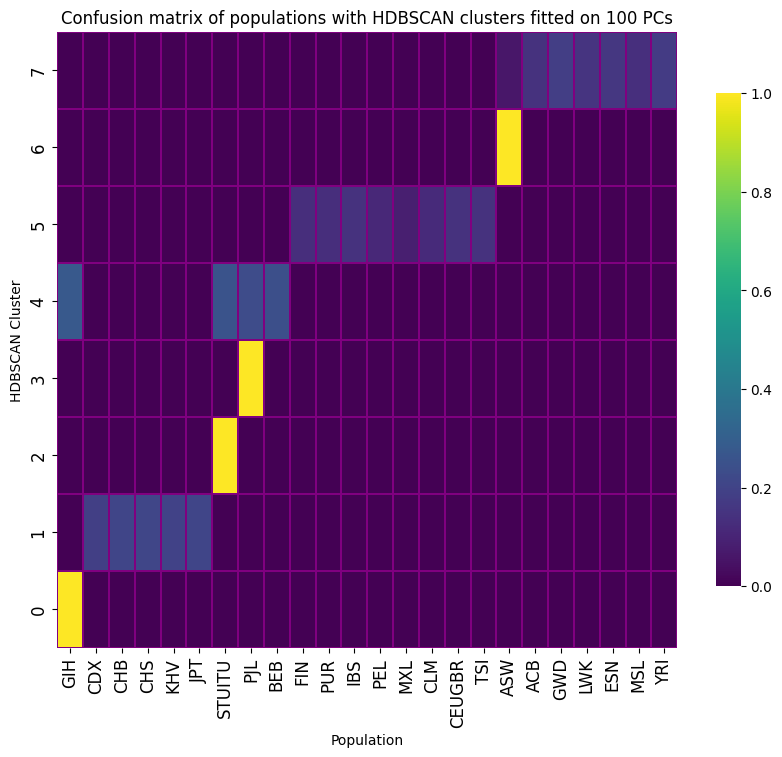

In [364]:
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(proportions, cmap='viridis', annot=False,linewidths=0.05, linecolor='purple', 
                      cbar_kws={'shrink': 0.8})
heatmap.invert_yaxis()
plt.xlabel('Population')
plt.ylabel('HDBSCAN Cluster')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=12)
plt.title('Confusion matrix of populations with HDBSCAN clusters fitted on 100 PCs', fontsize=12)

# Adjust the color bar tick labels font size
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
plt.show()

# PHATE

In [8]:
# initial phate embedding
phate_operator_10d = phate.PHATE(random_state=42, 
                                n_components=10, 
                                knn=5, 
                                decay=60,
                                n_pca=None)
phate_operator_10d.fit(pca_input)
phate_emb_10d = phate_operator_10d.transform()

Running PHATE on 2322 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.37 seconds.
  Calculating affinities...
  Calculated affinities in 0.06 seconds.
Calculated graph and diffusion operator in 0.44 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.11 seconds.
  Calculating KMeans...
  Calculated KMeans in 1.82 seconds.
Calculated landmark operator in 2.45 seconds.
Calculating optimal t...
  Automatically selected t = 25
Calculated optimal t in 1.14 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.45 seconds.
Calculating metric MDS...
Calculated metric MDS in 118.32 seconds.


In [536]:
# hdbscan parameters
min_points = 15# 25
eps = 0.0
min_samples = None
metric = 'euclidean'

In [532]:
# use hdbscan package
clusterer = hdbscan.HDBSCAN(min_cluster_size=min_points,min_samples=min_samples, 
                            gen_min_span_tree=True,leaf_size=3,
                            cluster_selection_epsilon=eps, metric = metric)
clusterer.fit(phate_emb_10d)
print('Number of clusters:', str(max(clusterer.labels_)))
print('Number unassigned:', str(np.sum(clusterer.labels_ == -1)))

Number of clusters: 18
Number unassigned: 119


In [537]:
# OR use sklearn
clusterer = sklearn.cluster.HDBSCAN(min_cluster_size=min_points, cluster_selection_epsilon=eps)
clusterer.fit(phate_emb_10d)

HDBSCAN(min_cluster_size=15)

In [538]:
# Calculate the ARI
ari_score_PHATE = adjusted_rand_score(label_with_names, clusterer.labels_)
ari_score_PHATE

0.6605559399088854

In [539]:
df = pd.DataFrame(columns=['HDBSCAN Cluster', 'Population'])
df['HDBSCAN Cluster'] = clusterer.labels_
df['Population'] = label_with_names

# Filter out the -1 cluster
df = df[df['HDBSCAN Cluster'] != -1]
# Create a cross-tabulation of clusters and populations
crosstab = pd.crosstab(df['HDBSCAN Cluster'], df['Population'])
# Convert counts to proportions
proportions = crosstab.div(crosstab.sum(axis=1), axis=0)

# Reorder the populations to match the clusters
ordered_populations = proportions.idxmax().sort_values().index
proportions = proportions[ordered_populations]

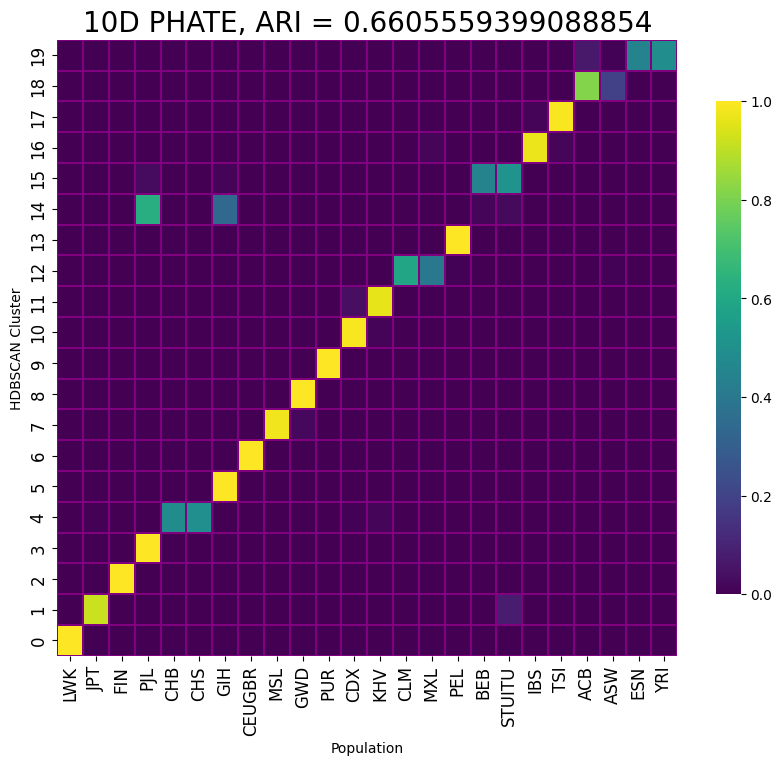

In [541]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(proportions, cmap='viridis', annot=False,linewidths=0.05, linecolor='purple', 
                      cbar_kws={'shrink': 0.8})
heatmap.invert_yaxis()
plt.xlabel('Population')
plt.ylabel('HDBSCAN Cluster')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=12)
plt.title(f'10D PHATE, ARI = {ari_score_PHATE}', fontsize=20)

# Adjust the color bar tick labels font size
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
plt.show()
# plt.savefig(Figure_PATH +'1000G_HDBSCAN_population.pdf', bbox_inches = 'tight')

# t-SNE

In [637]:
tsne_op = TSNE(n_components=10, perplexity=20, n_iter=800,random_state=42, method='exact') # , method='exact'
tsne_embedding = tsne_op.fit_transform(pca_input)

/home/mila/s/shuang.ni/.conda/envs/genetics/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [655]:
# hdbscan parameters
min_points = 2 # 25
eps = 1.7
min_samples = None
metric = 'euclidean'
alpha = 1.0

In [638]:
# OR use sklearn
clusterer = sklearn.cluster.HDBSCAN(min_cluster_size=min_points, cluster_selection_epsilon=eps)
clusterer.fit(tsne_embedding)
print('Number of clusters:', str(max(clusterer.labels_)))
print('Number unassigned:', str(np.sum(clusterer.labels_ == -1)))

Number of clusters: 42
Number unassigned: 0


In [656]:
# use hdbscan package
clusterer = hdbscan.HDBSCAN(min_cluster_size=min_points,min_samples=min_samples, alpha = alpha, 
                            gen_min_span_tree=True,leaf_size=2,
                            cluster_selection_epsilon=eps, metric = metric)
clusterer.fit(tsne_embedding)
print('Number of clusters:', str(max(clusterer.labels_)))
print('Number unassigned:', str(np.sum(clusterer.labels_ == -1)))

Number of clusters: 29
Number unassigned: 68


In [657]:
# Calculate the ARI
ari_score_tSNE = adjusted_rand_score(label_with_names, clusterer.labels_)
ari_score_tSNE

0.4239751820718473

In [658]:
df = pd.DataFrame(columns=['HDBSCAN Cluster', 'Population'])
df['HDBSCAN Cluster'] = clusterer.labels_
df['Population'] = label_with_names

# Filter out the -1 cluster
df = df[df['HDBSCAN Cluster'] != -1]
# Create a cross-tabulation of clusters and populations
crosstab = pd.crosstab(df['HDBSCAN Cluster'], df['Population'])
# Convert counts to proportions
proportions = crosstab.div(crosstab.sum(axis=1), axis=0)

# Reorder the populations to match the clusters
ordered_populations = proportions.idxmax().sort_values().index
proportions = proportions[ordered_populations]

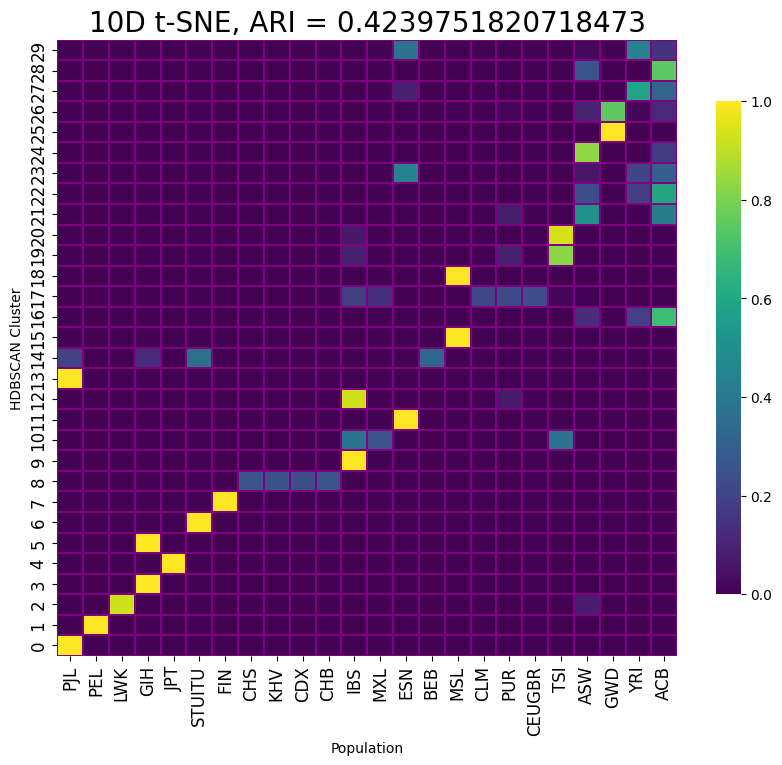

In [659]:

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(proportions, cmap='viridis', annot=False,linewidths=0.05, linecolor='purple', 
                      cbar_kws={'shrink': 0.8})
heatmap.invert_yaxis()
plt.xlabel('Population')
plt.ylabel('HDBSCAN Cluster')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=12)
plt.title(f'10D t-SNE, ARI = {ari_score_tSNE}', fontsize=20)

# Adjust the color bar tick labels font size
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
plt.show()
# plt.savefig(Figure_PATH +'1000G_HDBSCAN_population.pdf', bbox_inches = 'tight')

# PCA

In [96]:
pca_obj = sklearn.decomposition.PCA(n_components=10, random_state=42)
pca_embedding = pca_obj.fit_transform(inputs)

In [469]:
# hdbscan parameters
min_points = 4 # 25
eps = 0.0
min_samples = None
metric = 'euclidean'
alpha = 1.0

In [472]:
# use hdbscan package
clusterer = hdbscan.HDBSCAN(min_cluster_size=min_points,min_samples=min_samples, alpha = alpha,
                            gen_min_span_tree=True,leaf_size=2,
                            cluster_selection_epsilon=eps, metric = metric)
clusterer.fit(pca_embedding)
print('Number of clusters:', str(max(clusterer.labels_)))
print('Number unassigned:', str(np.sum(clusterer.labels_ == -1)))

Number of clusters: 19
Number unassigned: 141


In [471]:
# OR use sklearn
clusterer = sklearn.cluster.HDBSCAN(min_cluster_size=min_points, cluster_selection_epsilon=eps)
clusterer.fit(pca_embedding)
print('Number of clusters:', str(max(clusterer.labels_)))
print('Number unassigned:', str(np.sum(clusterer.labels_ == -1)))

Number of clusters: 20
Number unassigned: 104


In [473]:
# Calculate the ARI
ari_score_PCA = adjusted_rand_score(label_with_names, clusterer.labels_)
ari_score_PCA

0.6199205305107511

In [474]:
df = pd.DataFrame(columns=['HDBSCAN Cluster', 'Population'])
df['HDBSCAN Cluster'] = clusterer.labels_
df['Population'] = label_with_names

# Filter out the -1 cluster
df = df[df['HDBSCAN Cluster'] != -1]
# Create a cross-tabulation of clusters and populations
crosstab = pd.crosstab(df['HDBSCAN Cluster'], df['Population'])
# Convert counts to proportions
proportions = crosstab.div(crosstab.sum(axis=1), axis=0)

# Reorder the populations to match the clusters
ordered_populations = proportions.idxmax().sort_values().index
proportions = proportions[ordered_populations]

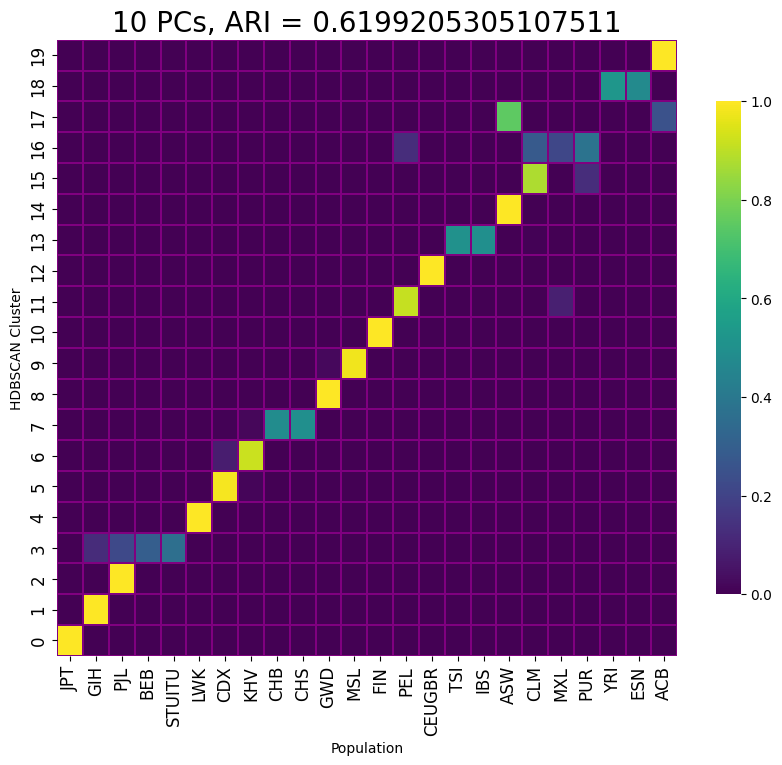

In [483]:
# 10 PCs
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(proportions, cmap='viridis', annot=False,linewidths=0.05, linecolor='purple', 
                      cbar_kws={'shrink': 0.8})
heatmap.invert_yaxis()
plt.xlabel('Population')
plt.ylabel('HDBSCAN Cluster')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=12)
plt.title(f'10 PCs, ARI = {ari_score_PCA}', fontsize=20)

# Adjust the color bar tick labels font size
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
plt.show()

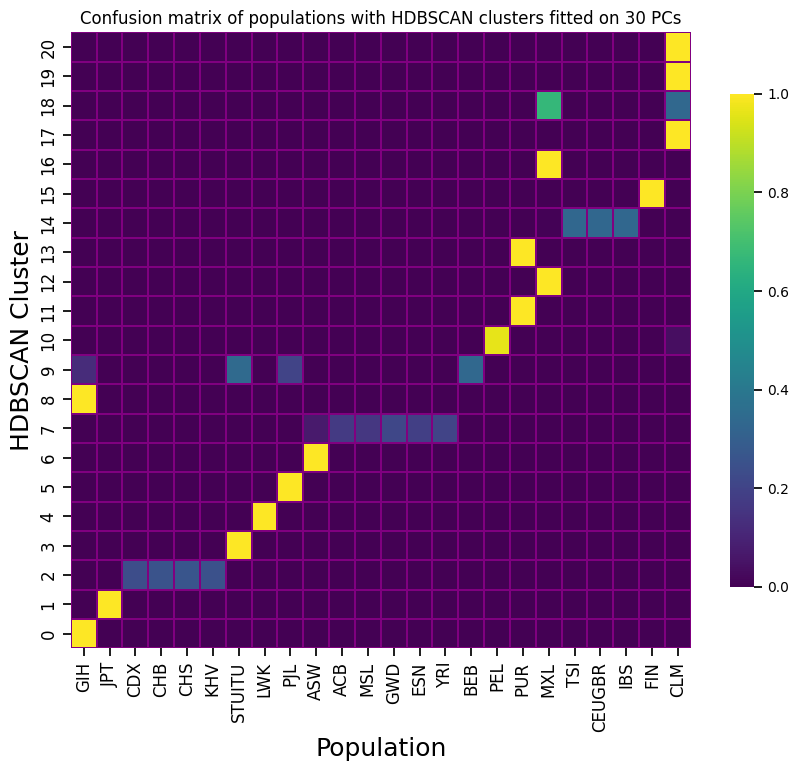

In [173]:
# 30 PCs
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(proportions, cmap='viridis', annot=False,linewidths=0.05, linecolor='purple', 
                      cbar_kws={'shrink': 0.8})
heatmap.invert_yaxis()
plt.xlabel('Population')
plt.ylabel('HDBSCAN Cluster')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=12)
plt.title('Confusion matrix of populations with HDBSCAN clusters fitted on 30 PCs', fontsize=12)

# Adjust the color bar tick labels font size
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
plt.show()